# 0.0 Imports

In [50]:
import re
import datetime
import inflection

import pandas           as pd
import numpy            as np
import seaborn          as sns
import umap.umap_       as umap
import matplotlib.cm    as cm

from plotly             import express          as px
from sklearn            import cluster          as ct
from sklearn            import metrics          as mt
from sklearn            import preprocessing    as pp
from matplotlib         import pyplot           as plt
from IPython.display    import HTML

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

## 0.2 Load Dataset

In [3]:
df_raw = pd.read_csv('../datasets/data.csv', encoding='ISO-8859-1')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 1.0 Descrição dos Dados

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list (map (snakecase, cols_old))

#
df1.columns = cols_new

## 1.2 Data dimensions

In [8]:
print ('Nmber of rows: {}'.format(df1.shape[0]))
print ('Nmber of columns: {}'.format(df1.shape[1]))

Nmber of rows: 541909
Nmber of columns: 8


## 1.3 Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA's

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [11]:
# Remove na
df1 = df1.dropna( subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0] / df_raw.shape[0])))


Removed data: 0.25


In [12]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Chance dtypes

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%m/%d/%Y %H:%M', errors='coerce')

df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## 1.7 Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m= pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


#### 1.7.1.1 Numerical Attributes - Investigating

In [17]:
# Quantity negativa ( pode ser devolução)
# Preço unitario igual a zero ( pode ser promoção?)

### 1.7.2 Categorical Atributes

In [18]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [19]:
# invoice number
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9+]', x))), 'invoice_no'].drop_duplicates())


3654

In [20]:
# stock code

# stock_code_wstring = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9+]', x))), 'stock_code'].drop_duplicates())
# print(stock_code_wstring)

cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()


#df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head(20)


array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2.0 Filtragem de Variáveis

In [21]:
df2 = df1.copy()

In [22]:
# ----- Numerical Attributes ----
# unit prince > 0.0
df2 = df2.loc[df2['unit_price'] > 0.010, :]

# stock code != [ POST, D, M, DOT, CRUK, C2]
df2 = df2[~df2['stock_code'].isin([ 'POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]

# description
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

# 3.0 Feature Engineering

In [31]:
df3 = df2.copy()

In [32]:
# data reference 

df_ref = df3.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 'country'] , axis=1).drop_duplicates(ignore_index=True)

In [33]:
# Gross Revenue (Faturamento) quantity * price = Faturamente

df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary 

df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()


customer_id       0
gross_revenue    27
dtype: int64

In [34]:
# Recency - Last day purchase
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [35]:
# Frequency
df_freq = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [36]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'], 2)
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [42]:
# Number of returns
df_returns = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'returns'})
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [44]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,371.0,34.0,18.15,1.0
1,13047,3232.59,56.0,9.0,18.90,7.0
2,12583,6705.38,2.0,15.0,28.90,2.0
3,13748,948.25,95.0,5.0,33.87,0.0
4,15100,876.00,333.0,3.0,292.00,3.0


In [ ]:
# # Gross Revenue (Faturamento) quantity * price = Faturamente

# df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# # Monetary 

# df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# # Recency - Last day purchase
# df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
# df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_recency = df_recency[['customer_id', 'recency_days']].copy()
# df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# # Frequency
# df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
# df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# # Avg Ticket
# df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'})
# df_avg_ticket.head()
# df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')


# 4.0 EDA (Exploratory Data Analysis)

In [45]:
df4 = df_ref.dropna().copy()

In [46]:
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
returns          0
dtype: int64

# 5.0 Data Preparation

In [47]:
df5 = df4.copy()

In [52]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['returns'] = ss.fit_transform(df5[['returns']])



# 6.0 Feature Selection

In [54]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning

In [55]:
X = df6.drop(columns=['customer_id'])

In [56]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Square (WWS)

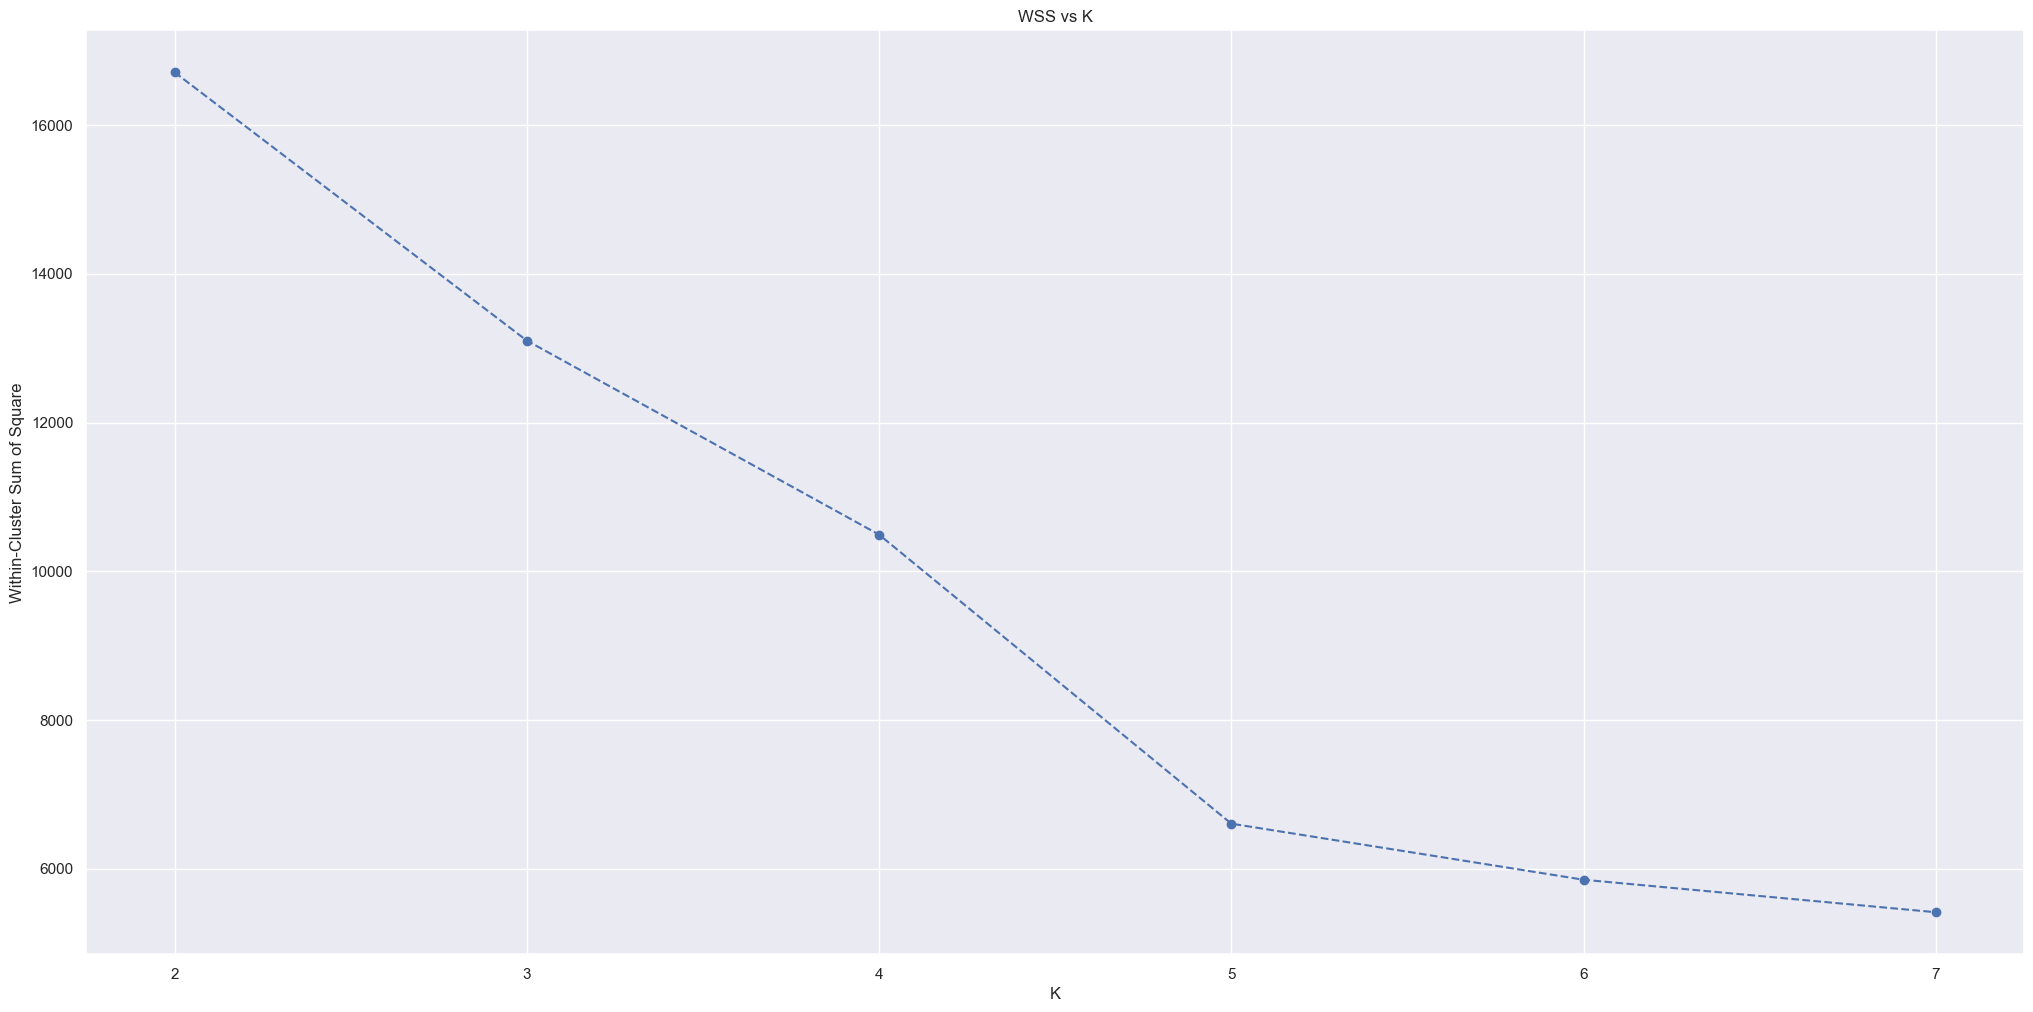

In [57]:
wss = []

for k in clusters:
    # definition
    model = ct.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # training/fit
    model.fit (X)

    # validation
    wss.append(model.inertia_)

# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

## 7.2 Sillhouette Score

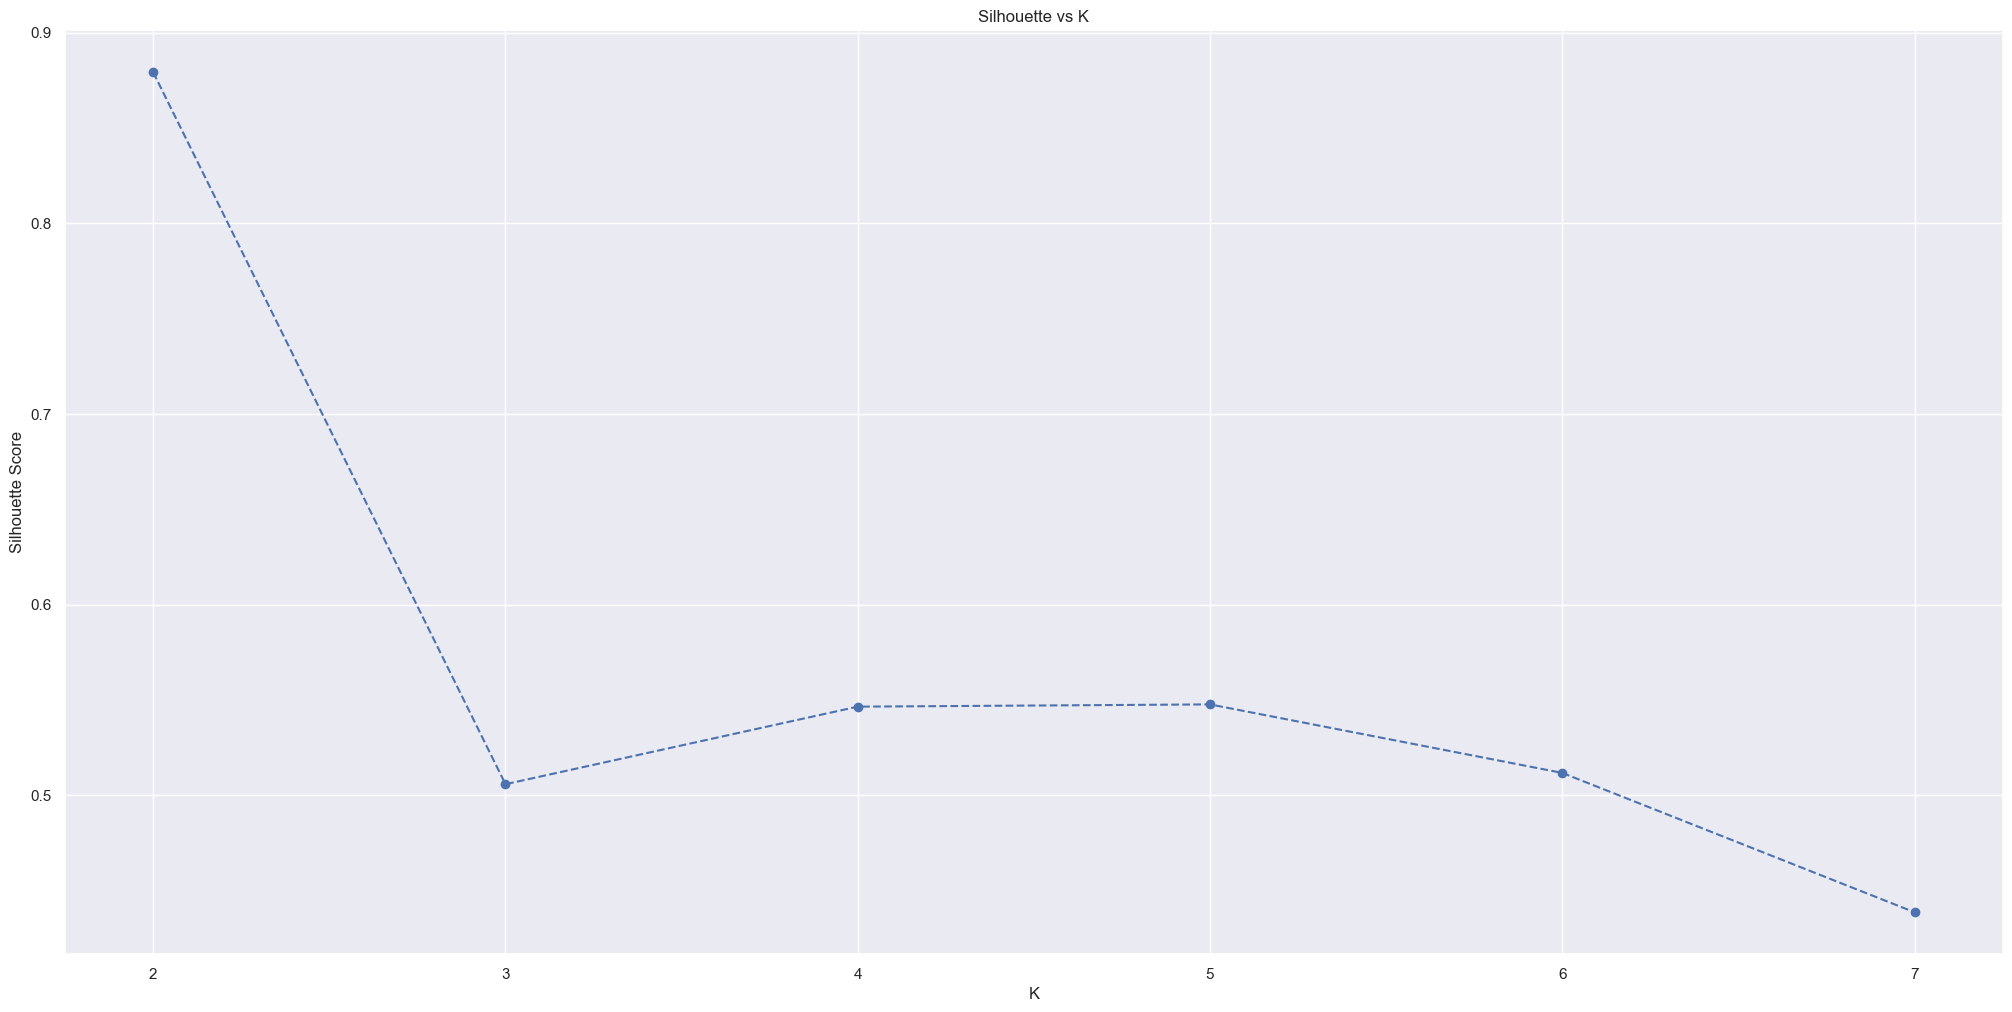

In [58]:
silhouette = []

for k in clusters:
    # definition
    model = ct.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # training/fit
    model.fit (X)

    # validation
    silhouette.append(mt.silhouette_score(X, model.labels_))

# plot wss
plt.plot(clusters, silhouette, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette vs K');

### 7.2.1 Silhouette Analysis

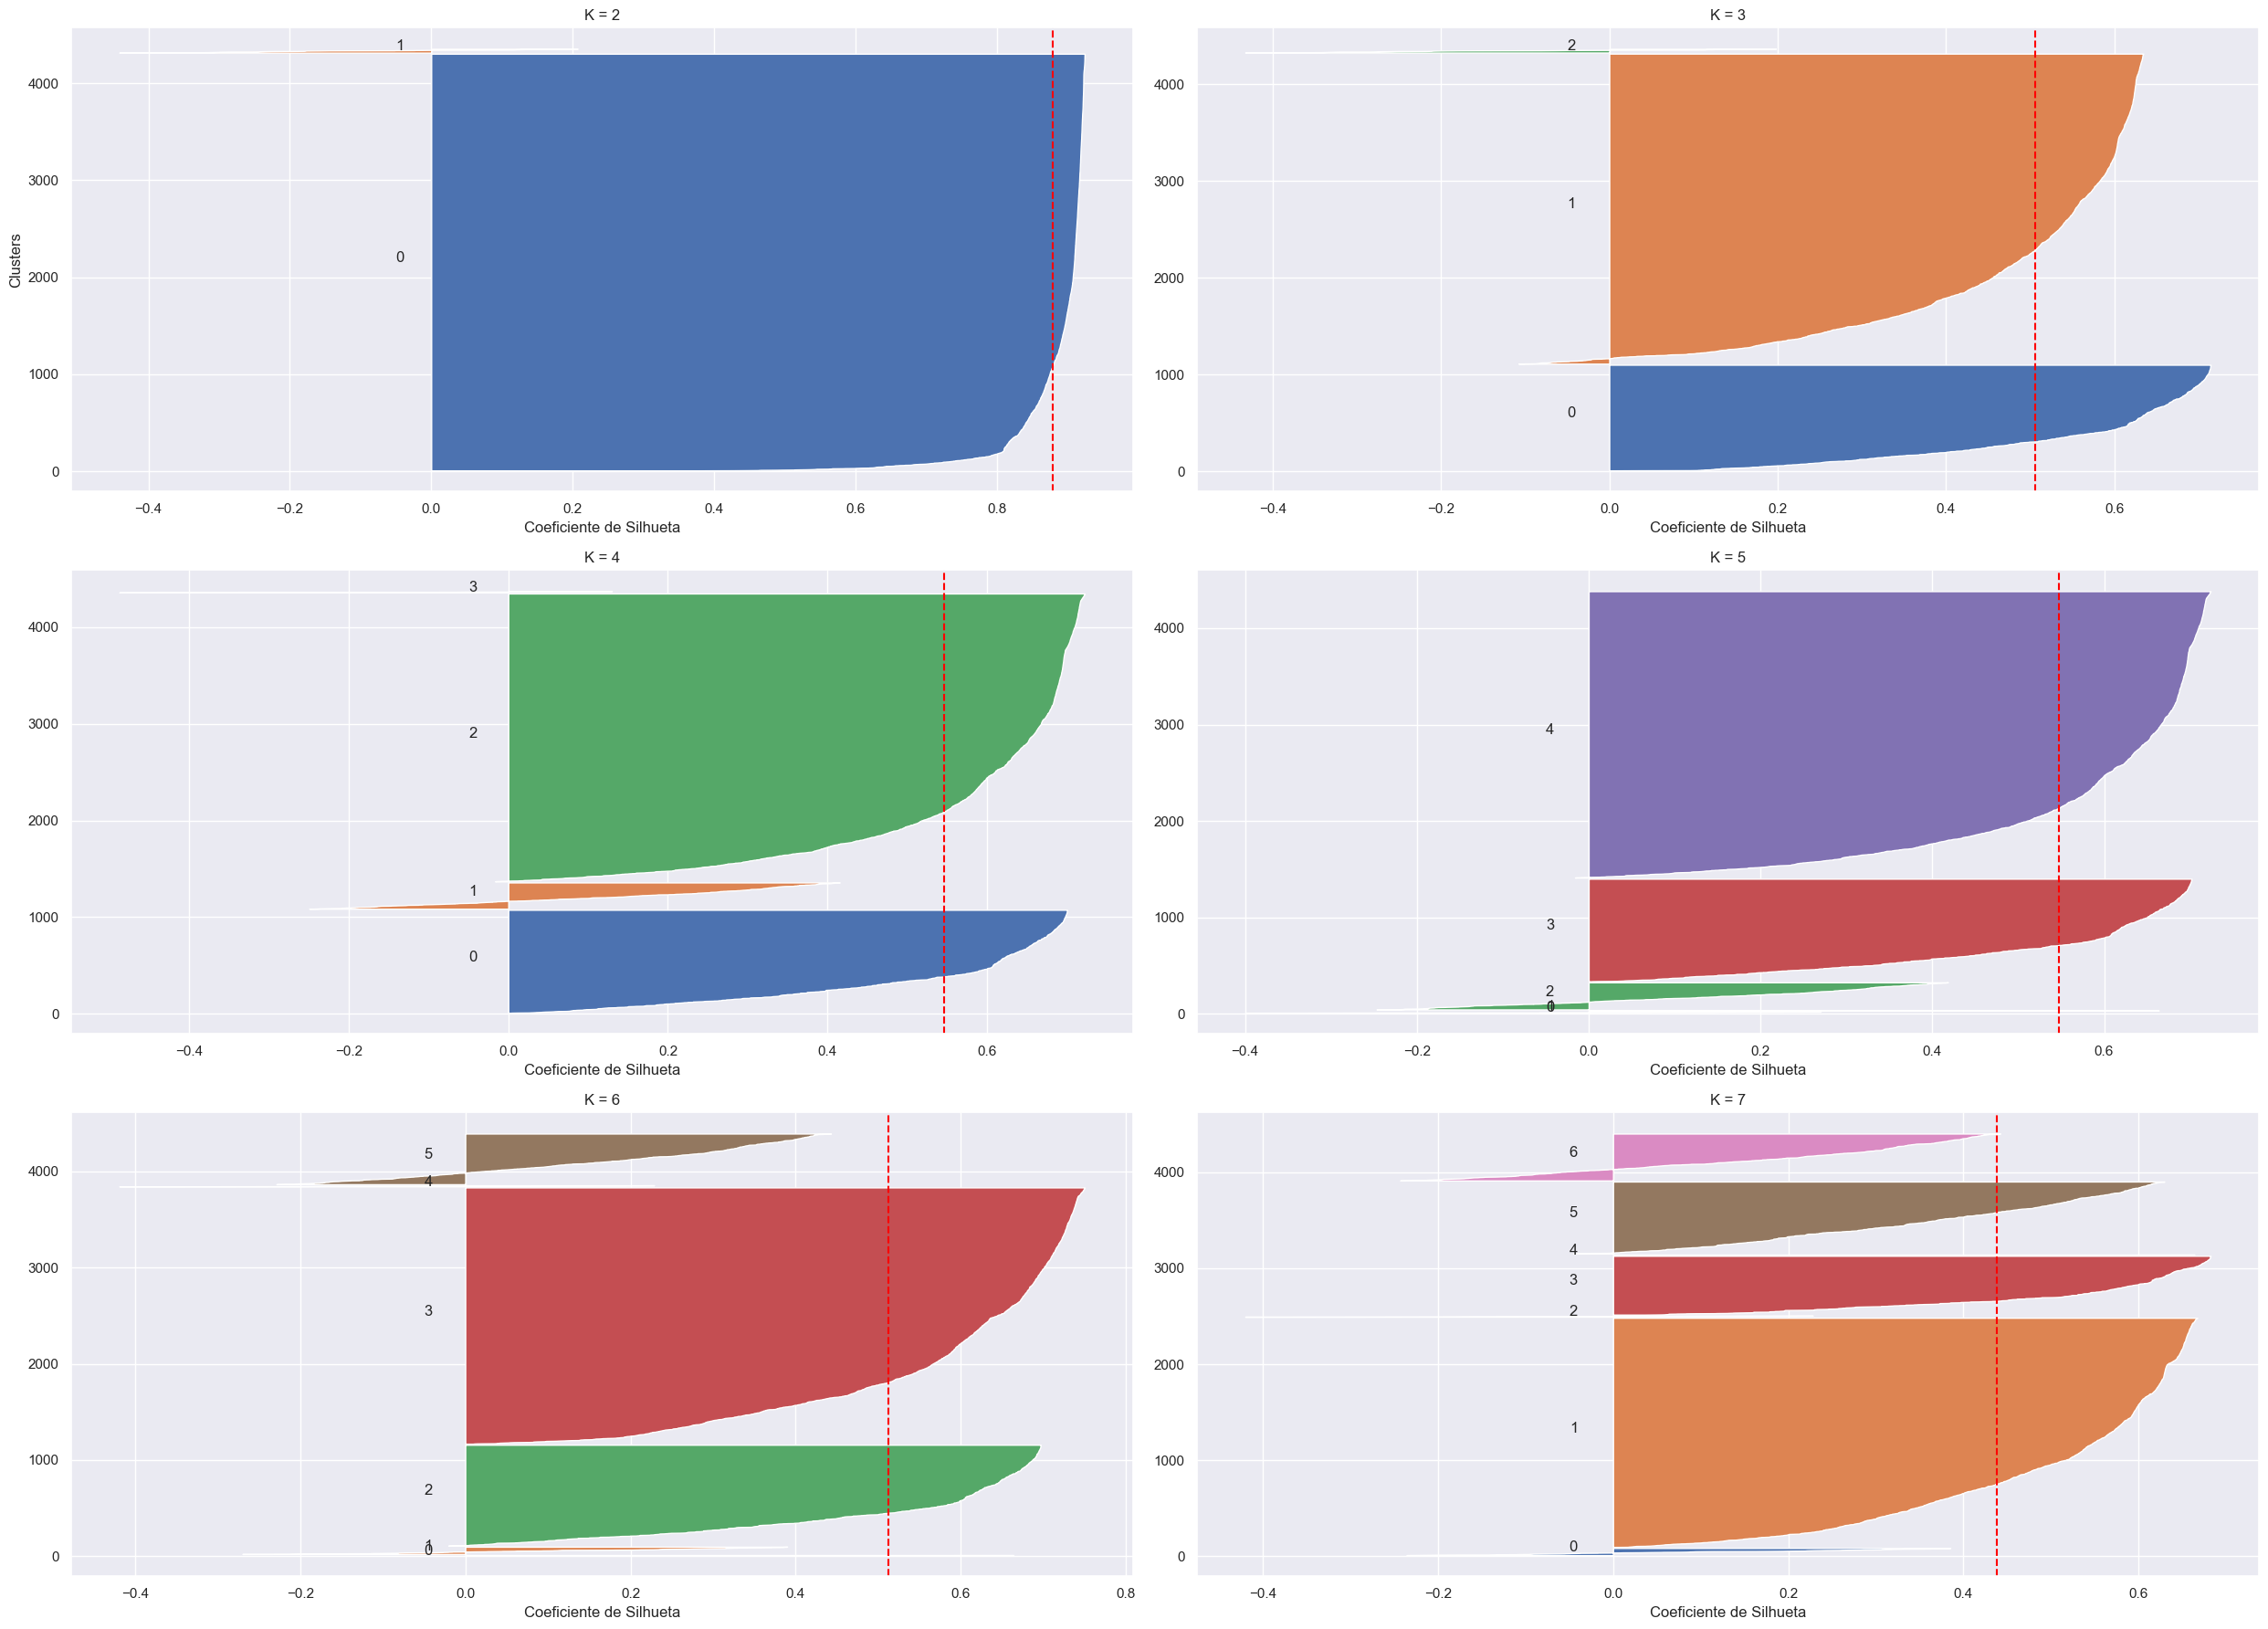

In [59]:
clusters = [2, 3, 4, 5, 6, 7]


# Criando subplots dinâmicos para os gráficos
fig, axes = plt.subplots(3, 2, figsize=(25, 18))

axes = axes.flatten()

for ax, k in zip(axes, clusters):

    # Criando e treinando o modelo KMeans
    model_KM = ct.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    labels = model_KM.fit_predict(X)

    # Calculando a pontuação da silhueta
    silhouette_avg = mt.silhouette_score(X, labels)
    silhouette_values = mt.silhouette_samples(X, labels)

    y_lower = 10  # Inicializando a posição no eixo Y para o primeiro cluster

    for i in range(k):
        # Filtrando os valores de silhueta para cada cluster
        cluster_silhouette_values = silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        # Criando a área preenchida do gráfico
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values)
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))  # Marcando o cluster
        y_lower = y_upper + 10  # Atualizando o Y para o próximo cluster

    # Linha média de silhueta
    ax.axvline(x=silhouette_avg, linestyle="--", color="red")
    ax.set_xlabel("Coeficiente de Silhueta")
    ax.set_ylabel("Clusters" if k == clusters[0] else "")
    ax.set_title(f"K = {k}")

# Ajustando o layout e exibindo os gráficos
plt.tight_layout()
plt.show()

# 8.0 Model Training

In [60]:
df8 = X.copy()

## 8.1 K-Means

In [61]:
# model definition
k=6
model = ct.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# training (fit)
model.fit (X)

#performance

labels = model.labels_

### 8.1.1 Cluster Validation

In [62]:
# WSS (Within-cluster sum of square)
print ('WSS value: {}'.format(model.inertia_))

## SS (Silhouette Score)
print('Silhouette Score: {}'.format(mt.silhouette_score(X, labels, metric='euclidean')))

WSS value: 5853.717410071924
Silhouette Score: 0.5117312098286475


# 9.0 Cluster Analysis

In [63]:
df9 = df6.copy()
df9['cluster'] = labels

In [64]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.378436,2.787476,3.895526,-0.033911,0.114969,2
1,13047,0.136044,-0.356391,0.622248,-0.033400,3.160125,5
2,12583,0.526004,-0.895340,1.407834,-0.026590,0.622495,5
3,13748,-0.120464,0.032849,0.098523,-0.023205,-0.392557,3
4,15100,-0.128577,2.408216,-0.163339,0.152580,1.130021,2


## 9.1 Visualization Inspections

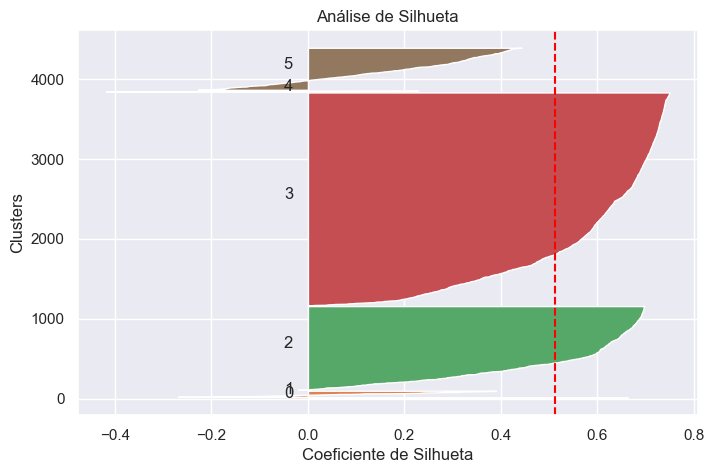

In [65]:

# Calculando a pontuação de silhueta
silhouette_avg = mt.silhouette_score(X, labels)
silhouette_values = mt.silhouette_samples(X, labels)

# Plotando os valores de silhueta
plt.figure(figsize=(8,5))
y_lower = 10
for i in range(k):
    cluster_silhouette_values = silhouette_values[labels == i]
    cluster_silhouette_values.sort()
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, linestyle="--", color="red")
plt.xlabel("Coeficiente de Silhueta")
plt.ylabel("Clusters")
plt.title("Análise de Silhueta")
plt.show()

## 9.2 2D-Plot


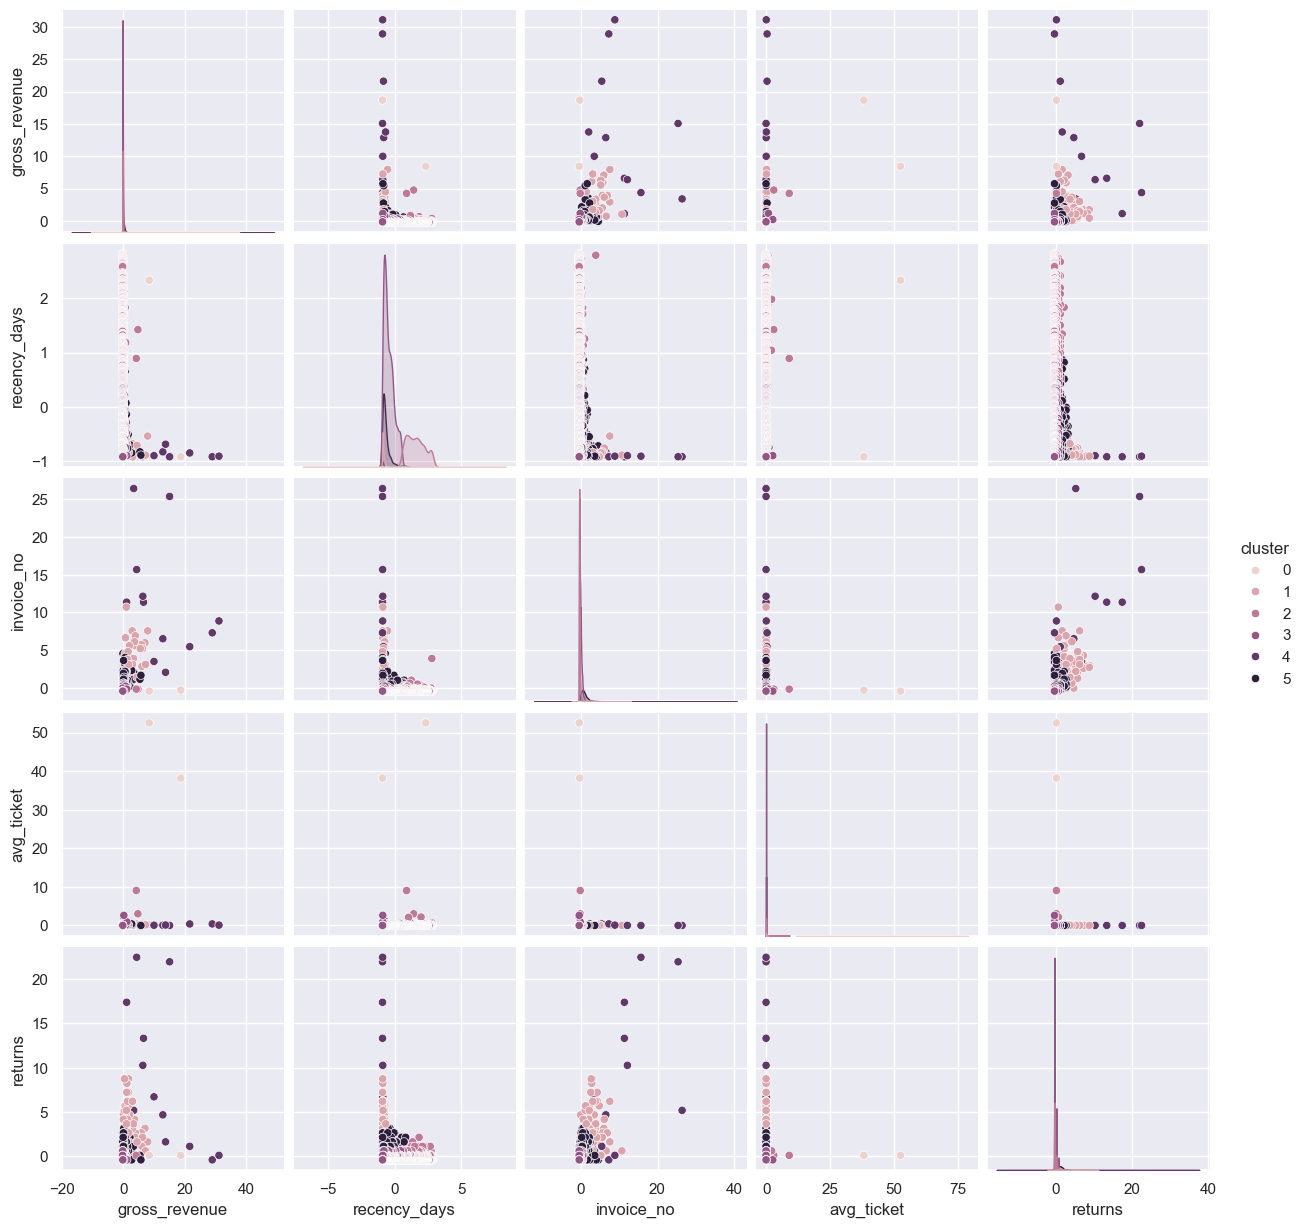

In [66]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot (df_viz, hue='cluster')


## 9.3 UMAP

d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Comunidade DS\Portifólio de Projetos\repos\ds_fidelidade\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

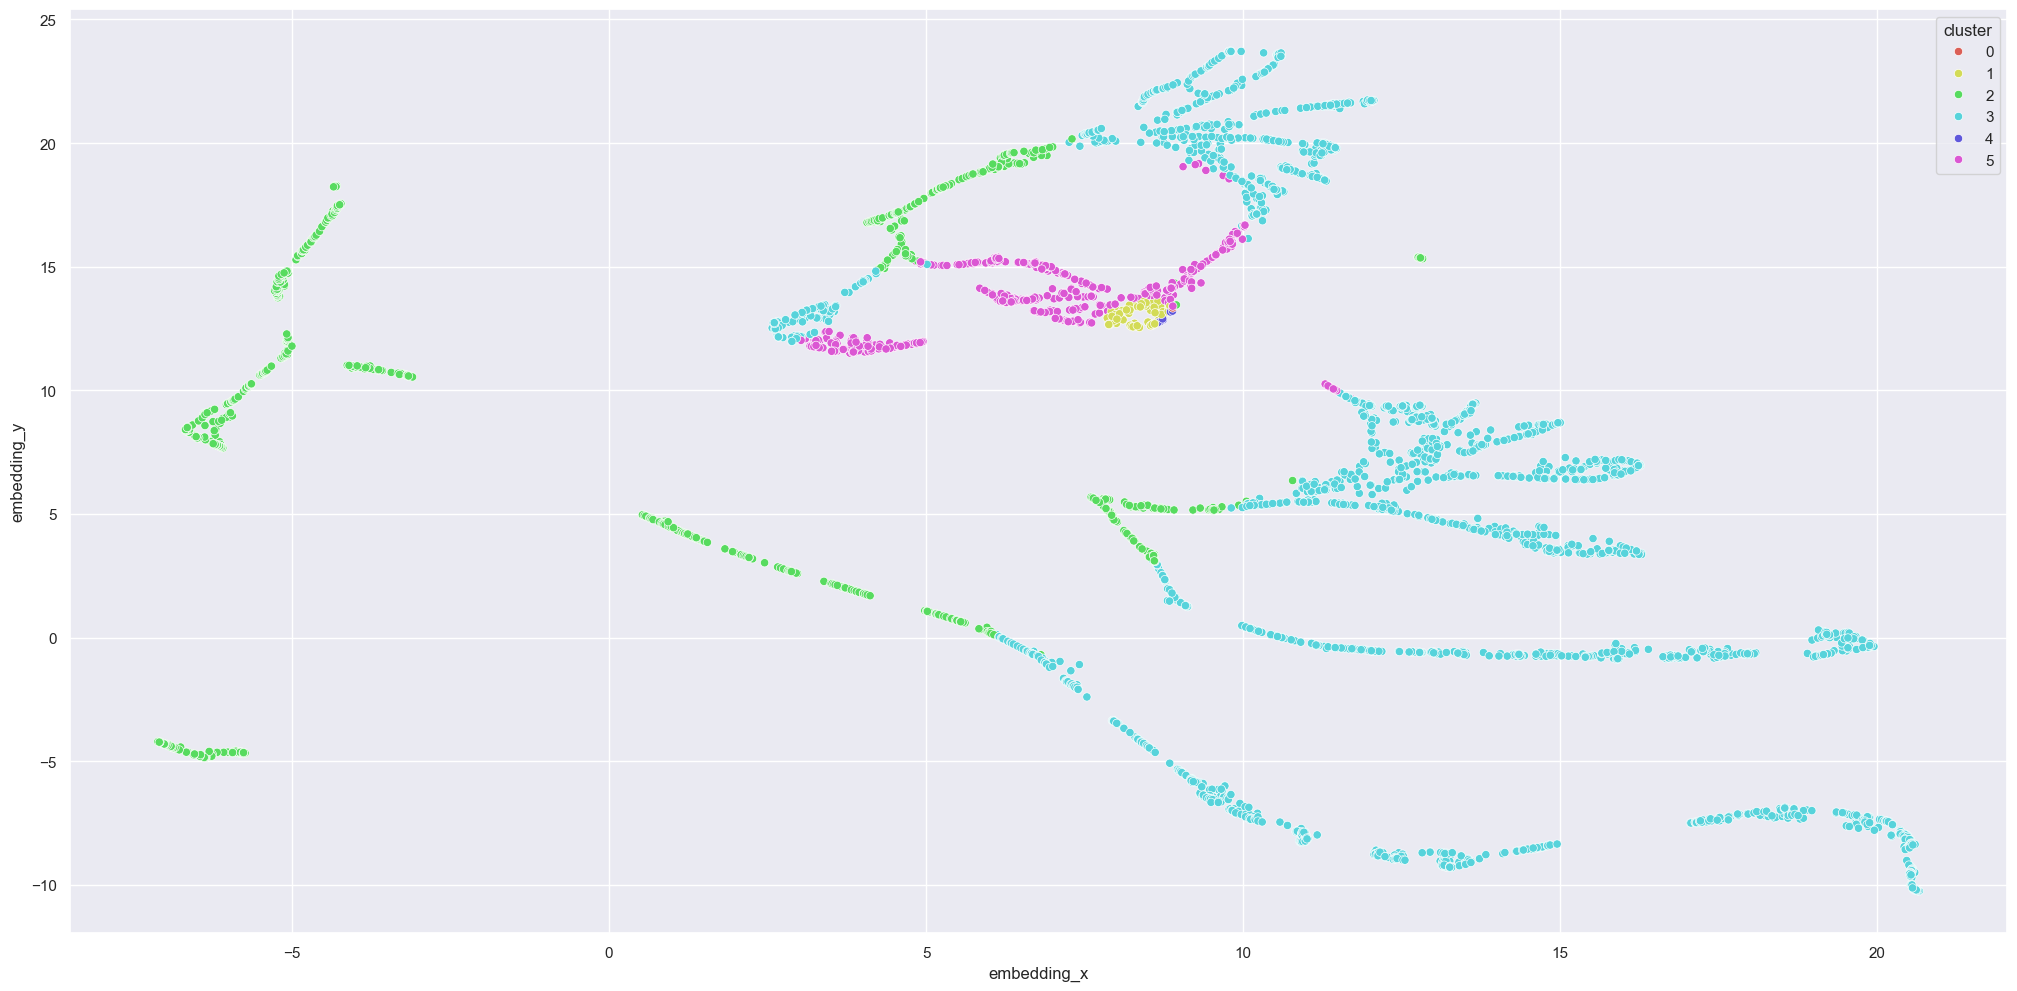

In [67]:
reducer = umap.UMAP(random_state=42, n_neighbors=20)
embedding = reducer.fit_transform(X)

# embedding

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot (x='embedding_x', y='embedding_y',
                 hue='cluster',
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data=df_viz)

## 9.2 Cluster Profile

In [45]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,301,35,16.950737,0
1,13047,3079.10,31,18,15.709694,3
2,12583,7187.34,2,18,28.634821,0
3,13748,948.25,95,5,33.866071,3
4,15100,635.10,329,6,105.850000,3


In [46]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='left', on='cluster')


In [47]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,267,6.107045,8089.028652,19.823970,19.528090,62.783157
1,1,6,0.137237,182181.981667,6.666667,89.000000,253.626345
2,2,28,0.640439,42614.387143,5.678571,57.821429,162.862605
3,3,4071,93.115279,946.696250,96.429870,3.641120,25.359654


### Cluster 01: (Canditado ao Loyalty)
        - Número de customers: 6 (0.14% dos customers)
        - Recência em média: 7 dias
        - Compras em média: 89 compras
        - Receita em média: $182.182,00 dólares

### Cluster 02:
        - Número de customers: 31 (0.7 % dos customers)
        - Recência em média: 14 dias
        - Compras em média: 53 compras 
        - Receita em média: $40.543,52 dólares

### Cluster 03:
        - Número de customers: 4.335 (99% dos customers)
        - Recência em média: 92 dias
        - Compras em média: 5 compras
        - Receita em média: $1.372,57 dólares

# 10.0 Deploy to Production